In [1]:
# https://canvas.vu.nl/courses/72644/files/folder/Assignments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

## Part 1: IRS

In [2]:
def standardized_maturities(zero_rates):
    """
    Standardize maturity indices for ECB data to yearly scaled indices.

    Parameters:
        zero_rates (pd.Series): Pandas Series containing zero rates with maturity indices.

    Returns:
        list: A list of standardized maturity values in years.

    This function standardizes the maturity indices provided in the ECB data to yearly scaled indices. It processes each
    maturity index, which can be in the format "X months" or "X years," and converts them into a yearly scale for
    consistent handling.
    """
    standardized_maturities = []
    for maturity in zero_rates.index:
        if 'month' in maturity:
            num_months = int(maturity.split()[0])
            standardized_maturities.append(num_months / 12.0)
        elif 'year' in maturity:
            num_years = int(maturity.split()[0])
            standardized_maturities.append(num_years)
        else:
            raise ValueError(f"Unrecognized maturity format: {maturity}")
    return standardized_maturities


In [44]:
usbond_df = pd.read_excel('data/usbond_data.xlsx')
bondtest_data = pd.read_excel('data/bondtest_data.xlsx')
european_zerorates = pd.read_excel('data/european_zerorates.xlsx')
european_zerorates = european_zerorates.set_index('Maturity')
european_zerorates =  european_zerorates['AAA rated']/100 #make percentages
european_zerorates.index = standardized_maturities(european_zerorates)

In [34]:
def get_euribordata():
    """
    Fetch Euribor rates data from an API.

    Returns:
        dict: A dictionary containing Euribor rates for different tenors.

    This function sends an API request to retrieve Euribor rates data and then extracts and organizes the rates
    for tenors of 3 months, 6 months, and 12 months into a dictionary. The function returns this dictionary.
    """
    url = "https://euribor.p.rapidapi.com/all"

    headers = {
        "X-RapidAPI-Key": "46bc3a6f18mshb2d07e9eb01ef29p1c2d78jsn578089492ef1",
        "X-RapidAPI-Host": "euribor.p.rapidapi.com"
    }

    EURIBOR = requests.get(url, headers=headers).json()
    
    euribor_rates = {
        '3months': EURIBOR['3months']/100,
        '6months': EURIBOR['6months']/100,
        '12months': EURIBOR['12months']/100
    }
    return euribor_rates

get_euribordata()

{'3months': 0.03997, '6months': 0.040970000000000006, '12months': 0.04064}

In [38]:
def get_esterdata():
    API_KEY = 'Jcu52w5Gpb+4VrQI58md/A==lPpZWr0GtZ9GlZzg'
    api_url = 'https://api.api-ninjas.com/v1/interestrate'
    response = requests.get(api_url, headers={'X-Api-Key': API_KEY}).json()

    ester_rate_pct = None
    for item in response["non_central_bank_rates"]:
        if item["name"] == "ESTER":
            ester_rate_pct = item["rate_pct"]/100
    return ester_rate_pct

get_esterdata()

0.03902

In [74]:
#####mijn manier maar werkt maar tot 10 jaar en daarna pakt ie niet de goede sprongen
from scipy.interpolate import interp1d

euribor_rates = get_euribordata()
euribor_rates = [0.03896, 0.03834, euribor_rates['3months']/100, euribor_rates['6months']/100, euribor_rates['12months']/100]

bond_price_coupon_1proc = [
    95.81, 94.39, 92.89, 91.25, 89.74, 88.11, 86.34, 84.47, 82.58,
    74.03, 67.92, 63.21, 58.73
]

bond_maturities = [
    2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30
]

face_value = 100
payments_per_year = 1
coupon_rate = 1

def bootstrap_zero_curve_bonds(bond_price_coupon_1proc, bond_maturities, payments_per_year, face_value, euribor_rates, coupon_rate):
    zero_rates = {}    
    for i, maturity in enumerate(bond_maturities):

        bond_price = bond_price_coupon_1proc[i]

        if coupon_rate/100 == 0:
            zero_rate = -np.log(bond_price / face_value) * (1 / maturity)
            
        else:
            discounted_coupon = []

            for t in np.arange(0.5, maturity + 0.5, 0.5):

                if t in zero_rates:
                    discount_factor  =  np.exp(-zero_rates[t] * payments_per_year * (t + 1))
                    cash_flow = -coupon_rate * discount_factor
                    discounted_coupon.append(cash_flow)
                
        
            coupon_payment = np.sum(discounted_coupon)
            zero_rate = -np.log((bond_price + coupon_payment) / (face_value+coupon_rate)) * (1 / maturity)
            
        zero_rates[maturity] = zero_rate

    zero_curve = pd.DataFrame(columns=['Maturity', 'Zero_Rate'])

    for maturity, zero_rate in zero_rates.items():
        zero_curve.loc[len(zero_curve)] = [maturity, zero_rate]
    
    return zero_curve

zero_curve = bootstrap_zero_curve_bonds(bond_price_coupon_1proc, bond_maturities, payments_per_year, face_value, euribor_rates, coupon_rate)

plt.plot(zero_curve['Zero_Rate'])
plt.show()

Interpolating for maturity 2 at time 0.5


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

1.0 -0.1 0.01 [2, 3, 4, 5, 6, 7, 8, 9, 10]


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

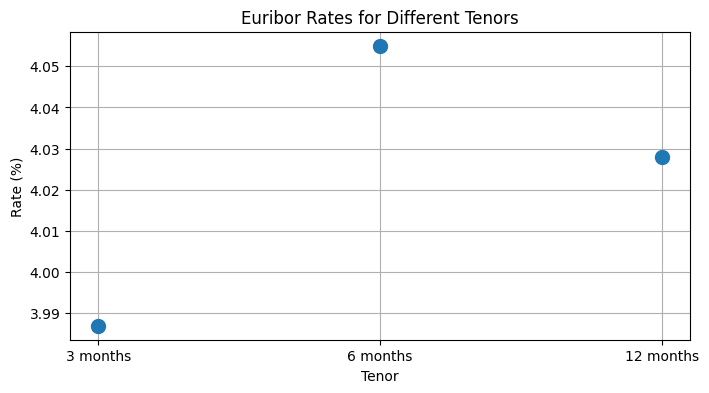

In [7]:
euribor_rates = get_euribordata()
tenors = ['3 months', '6 months', '12 months']
rates = [euribor_rates['3months'], euribor_rates['6months'], euribor_rates['12months']]

plt.figure(figsize=(8, 4))
plt.plot(tenors, rates, 'o', markersize=10)  # 'o' creates circular markers
plt.title('Euribor Rates for Different Tenors')
plt.xlabel('Tenor')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.show()

In [193]:
def __determine_paymentfrequency(payment_frequency):
    """
    Determine the Pandas frequency string and number of months for a given payment frequency.

    Parameters:
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).

    Returns:
        tuple: A tuple containing the Pandas frequency string and the number of months in the frequency.

    This private function maps a payment frequency to a Pandas frequency string and returns it along with the
    corresponding number of months in that frequency. It is used to determine the frequency for date range generation.
    """
    if payment_frequency == 0.5:  # Semi-annual
        freq_str = '6M'
        months = 6
    elif payment_frequency == 0.25:  # Quarterly
        freq_str = '3M'
        months = 3
    elif payment_frequency == 1:  # Annual
        freq_str = '12M'
        months = 12
    else:
        raise ValueError(f"Unsupported payment frequency: {payment_frequency}")
    return freq_str, months

def create_amortization_schedule(start_date, end_date, notional_amount, final_notional, payment_frequency):
    freq_rt = __determine_paymentfrequency(payment_frequency)[0]
    amortization_dates = pd.date_range(start=start_date, end=end_date, freq=freq_rt)
    num_periods = len(amortization_dates)
    amortization_steps = (notional_amount - final_notional) / (num_periods - 1)
    notional_amounts = []
    for i in range(num_periods):   
        amortized_notional = notional_amount - i * amortization_steps
        notional_amounts.append(amortized_notional)
    return dict(zip(amortization_dates, notional_amounts))

## Cashflows: 

In [189]:
def calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, reference_rate, amortization_schedule):
    """
    Calculate floating cash flows for an interest rate swap.

    Parameters:
        notional_amount (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).
        reference_rate (dict): Dictionary containing reference rates for different tenors.

    Returns:
        list: A list of floating cash flows.

    This function calculates floating cash flows for an interest rate swap with a reference rate. It determines payment
    dates based on the specified payment frequency, then computes the floating cash flows for each payment date,
    excluding the start date, using the corresponding reference rate for the given tenor.
    """

    floating_cashflows = []
    
    if isinstance(reference_rate, dict):
        rate_key = f'{months}months'
        rate = reference_rate.get(rate_key, None)
        if rate is None:
            raise ValueError(f"No rate found for {rate_key} in reference_rate dictionary")
    else: 
        interpolated_rates = interpolating_zero_rate(reference_rate, payment_dates)

    for idx, date in enumerate(payment_dates):
        if date != start_date:
            if not isinstance(reference_rate, dict):
                rate = interpolated_rates[idx] 
            current_notional = amortization_schedule[date] if amortization_schedule else notional_amount
            floating_cash_flow = current_notional * rate * payment_frequency
            floating_cashflows.append(floating_cash_flow)             

    return floating_cashflows


def calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, fixed_rate, amortization_schedule):
    """
    Calculate fixed cash flows for an interest rate swap.

    Parameters:
        notional_amount (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).
        fixed_rate (float): The fixed interest rate for the swap.

    Returns:
        tuple: A tuple containing a list of fixed cash flows and payment dates.

    This function calculates fixed cash flows for an interest rate swap with a fixed rate. It determines payment dates
    based on the specified payment frequency, then computes the fixed cash flows for each payment date, excluding the
    start date, and returns them as a list along with the payment dates.
    """

    fixed_cash_flows = []

    for date in payment_dates:
        if date != start_date:
            current_notional = amortization_schedule[date] if amortization_schedule else notional_amount
            fixed_cash_flow = current_notional * fixed_rate * payment_frequency
            fixed_cash_flows.append(fixed_cash_flow)
    
    return fixed_cash_flows

def interpolating_zero_rate(zero_curve, payment_dates):
    """
    Interpolate zero rates for a list of payment dates using a zero curve.

    Parameters:
        zero_curve (pd.Series): A Pandas Series containing zero rates for various maturities.
        payment_dates (list): List of payment dates corresponding to the zero rate interpolation.

    Returns:
        np.array: An array of interpolated zero rates for the provided payment dates.

    This function interpolates zero rates for a list of payment dates based on a given zero curve. It calculates the
    time to maturity in years for each payment date, then uses interpolation to estimate the zero rates for those
    dates. The function returns an array of interpolated zero rates.
    """
    
    start_date = payment_dates[0]
    years_to_maturity = (payment_dates - start_date).total_seconds() / (365 * 24 * 60 * 60)
    interpolating_function = interp1d(zero_curve.index, zero_curve, fill_value="extrapolate", bounds_error=False)
    interpolated_rates = interpolating_function(years_to_maturity)

    return interpolated_rates


def discount_cash_flows(cash_flows, payment_dates, zero_curve, payment_frequency):
    """
    Calculate the discounted cash flows for a given set of cash flows and payment dates using a zero curve.

    Parameters:
        cash_flows (list): List of cash flow values.
        payment_dates (list): List of payment dates corresponding to the cash flows.
        zero_curve (dict): Dictionary containing zero rates for various maturities.
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).

    Returns:
        float: The sum of the discounted cash flows.
    """

    discounted_cash_flows = []
    start_date = payment_dates[0]

    # Interpolate the zero rates for the cash flow dates
    interpolated_rates = interpolating_zero_rate(zero_curve, payment_dates)

    for cash_flow, rate, date in zip(cash_flows, interpolated_rates, payment_dates):
        ttm = (date - start_date).days / 365.0  # Time to maturity in years
        discount_factor = np.exp(-rate * ttm / payment_frequency)
        discounted_cash_flows.append(cash_flow * discount_factor)

    return sum(discounted_cash_flows)    

## Discount rates:

In [9]:
def determine_discount_rate(payment_frequency, yield_curve, one_curve=True):
    """
    Determine discount rates based on yield curve and payment frequency.

    Parameters:
        payment_frequency (float): Payment frequency (e.g., 0.25 for quarterly, 0.5 for semi-annual, 1 for annual).
        yield_curve (dict): Dictionary containing yield curve data, including zero rates and Euribor rates.
        one_curve (bool): Boolean flag to indicate whether to use a single curve or two curves.

    Returns:
        list or tuple: List of zero rates or tuple of zero rates and floating discount rates.

    This function determines discount rates based on the provided yield curve data and payment frequency.
    If 'one_curve' is True, it returns the zero rates for the specified payment frequency.
    If 'one_curve' is False, it calculates interpolated zero rates and floating discount rates for the given
    payment frequency and returns a tuple containing zero rates and floating discount rates.
    """
    supported_frequencies = [0.25, 0.5, 1.0]
    
    if one_curve:
        zero_rates = yield_curve['zero_rate']
        if payment_frequency in supported_frequencies:
            return zero_rates
        else:
            raise ValueError("Unsupported payment frequency. Only 0.25 (quarterly), 0.5 (semi-annual), and 1.0 (annual) are supported.")
    else:
        zero_rates = yield_curve['zero_rate']
        euribor_rates = yield_curve['euribor']

        supported_frequencies = [0.25, 0.5, 1.0]  # Supported payment frequencies
        if payment_frequency in supported_frequencies:
            return zero_rates, euribor_rates
        
        # Hier kunnen we nog andere frequencies toevoegen. 

        # # Interpolate zero rates and Euribor rates
        # interpolated_zero_rates = np.interp(np.arange(0.25, max(zero_rates.keys()) + 0.25, payment_frequency), list(zero_rates.keys()), list(zero_rates.values()))
        # interpolated_euribor_rates = np.interp(np.arange(0.25, max(euribor_rates.keys()) + 0.25, payment_frequency), list(euribor_rates.keys()), list(euribor_rates.values()))
        # # Calculate floating discount rates
        # floating_discount_rates = get_floating_discount_rates(payment_frequency, euribor_rates)
        # return yield_curve['zero_rate'], floating_discount_rates

In [97]:
def calc_swaprate(notional_amount, payment_dates, start_date, months, payment_frequency, swap_rates, zero_rates, amortization_schedule):
    guess_rate = 0.01 #adjusting rate (precision)
    tolerance = 0.001 #difference pv between floating and fixed rate
    max_iterations = 100 
    delta_rate = 0.0001

    for i in range(max_iterations):
        floating_cash_flows = calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, swap_rates['euribor'], amortization_schedule)
        fixed_cash_flows = calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, guess_rate, amortization_schedule)

        discounted_floating = discount_cash_flows(floating_cash_flows, payment_dates, zero_rates, payment_frequency)
        discounted_fixed = discount_cash_flows(fixed_cash_flows, payment_dates, zero_rates, payment_frequency)
        pv_difference = discounted_fixed - discounted_floating

        fixed_cash_flows_delta = calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, guess_rate + delta_rate, amortization_schedule)
        discounted_fixed_delta = discount_cash_flows(fixed_cash_flows_delta, payment_dates, zero_rates, payment_frequency)
        pv_difference_delta = discounted_fixed_delta - discounted_floating

        derivative = (pv_difference_delta - pv_difference) / delta_rate
        
        # Update guess_rate using Newton-Raphson formula
        if abs(derivative) > 1e-10:  # Avoid division by zero
            guess_rate -= pv_difference / derivative
        else:
            break
        
        if abs(pv_difference) < tolerance: 
            return guess_rate
        
        guess_rate += pv_difference * 0.001  # Simplified adjustment, use a proper numerical method

    raise ValueError("Swap rate not found within maximum iterations")

In [184]:
def IRS_enginge(notional_amount, start_date, end_date, payment_frequency, fixed_rate, amortization_schedule=None, one_curve=True, is_at_initiation = True):
    """
    Calculate the net present value (NPV) of an interest rate swap.

    Parameters:
        zero_rate (pd.Series or float): Zero rates for discounting or a single zero rate if 'one_curve' is True.
        notional (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.25 for quarterly, 0.5 for semi-annual, 1 for annual).
        fixed_rate (float): The fixed interest rate for the swap.
        swap_type (str, optional): Type of interest rate swap (default is 'fixed_vs_floating').
        amortization_schedule (list, optional): Amortization schedule if applicable (default is None).
        one_curve (bool, optional): Boolean flag to indicate whether to use a single curve or two curves (default is True).

    Returns:
        float: The net present value (NPV) of the interest rate swap.

    This function calculates the NPV of an interest rate swap based on the provided parameters. It takes into account the
    type of swap, payment frequency, and whether to use a single curve or two curves for discounting.
    """

    swap_rates = {'euribor': get_euribordata(), 'ester': get_esterdata(), 'fixed_rate': fixed_rate}
    zero_rates = european_zerorates
     
    freq_str, months = __determine_paymentfrequency(payment_frequency)
    payment_dates = pd.date_range(start=start_date, end=end_date, freq=freq_str)

    if one_curve == True:
        floating_rate_curve = zero_rates
        discount_rate_cash_flow = zero_rates
    else: 
        floating_rate_curve = swap_rates['euribor']
        discount_rate_cash_flow = zero_rates

    if is_at_initiation == False: 
        floating_cash_flows = calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, floating_rate_curve, amortization_schedule)
        fixed_cash_flows = calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, swap_rates['fixed_rate'], amortization_schedule)

        discounted_floating = discount_cash_flows(floating_cash_flows, payment_dates, discount_rate_cash_flow, payment_frequency)
        discounted_fixed = discount_cash_flows(fixed_cash_flows, payment_dates, discount_rate_cash_flow, payment_frequency)

        npv = discounted_fixed - discounted_floating
        print(f'NPV using the fixed rate ({swap_rates["fixed_rate"]}): {npv}')
        return npv
    else:
        swap_rate = calc_swaprate(notional_amount, payment_dates, start_date, months, payment_frequency, swap_rates, zero_rates, amortization_schedule)
        print(f'Swap rate equals: {np.round(swap_rate,10)}')

        return swap_rate
        

In [194]:
notional_amount = 100
start_date = pd.to_datetime('2023-01-01')
end_date_1 = start_date + pd.DateOffset(years=10)

amortization_schedule_1 = create_amortization_schedule(start_date, end_date_1, notional_amount, 0, payment_frequency)

fixed_rate = 0.04  # 3% fixed rate
payment_frequency = 1  # Semi-annual payments
is_at_initiation = False 
curve_settings = False #true if one curve, false if two curve

result = IRS_enginge(notional_amount, start_date, end_date_1, payment_frequency, fixed_rate, amortization_schedule=amortization_schedule_1, one_curve=curve_settings, is_at_initiation = is_at_initiation)

NPV using the fixed rate (0.04): -0.1303248310101317


In [163]:
def adjust_rates(df, basis_points): 
    """"Assignment 1 SPFII Derivatives.pdf"
    
    """

    adjustments = basis_points/1000 #to decimals
    return df + adjustments

In [197]:
Scenarios = {}

print("####################### Scenario 1 ###########################")
# Scenario 1: 
end_date_1 = start_date + pd.DateOffset(years=2)
amortization_schedule_1 = create_amortization_schedule(start_date, end_date_1, notional_amount, 50, payment_frequency)
fixed_rate = 0.03
IRS_enginge(notional_amount, start_date, end_date_1, payment_frequency, fixed_rate, amortization_schedule=None, one_curve=True, is_at_initiation = is_at_initiation)

print("####################### Scenario 2 ###########################")
# Scenario 2: 
Scenarios['scenario_2'] = {}

# For 5-year and 7 year swap
end_date_2_5yr = start_date + pd.DateOffset(years=5)
amortization_schedule_2_5yr = create_amortization_schedule(start_date, end_date_2_5yr, notional_amount, 50, payment_frequency)
amortization_schedule_list = [None, amortization_schedule_2_5yr] 
adjust_rates_list = [0, 25,50, 100, 150]
short_term_years = [5, 7]

for year in short_term_years:
    print(f'> Year: {year}')
    Scenarios['scenario_2'][f'{year}yr'] = {}

    end_date_2 = start_date + pd.DateOffset(years=year)
    amortization_schedule_2 = create_amortization_schedule(start_date, end_date_2, notional_amount, 50, payment_frequency)
    amortization_schedule_list = [None, amortization_schedule_2] 

    for rate in adjust_rates_list:
        print(f'>> Change rate: {rate}')

        adjusted_rates = adjust_rates(european_zerorates.copy(), rate)
        Scenarios['scenario_2'][f'{year}yr'][f'{rate}%'] = {}
        for schedule in amortization_schedule_list:
            if schedule == None:
                Scenarios['scenario_2'][f'{year}yr'][f'{rate}%']['No'] = IRS_enginge(notional_amount, start_date, end_date_2, payment_frequency, fixed_rate, amortization_schedule=schedule, one_curve=True, is_at_initiation = is_at_initiation)
            else: 
                Scenarios['scenario_2'][f'{year}yr'][f'{rate}%']['Yes'] = IRS_enginge(notional_amount, start_date, end_date_2, payment_frequency, fixed_rate, amortization_schedule=schedule, one_curve=True, is_at_initiation = is_at_initiation)

print("####################### Scenario 3 ###########################")

# Scneario 3: 
Scenarios['scenario_3'] = {}

for years in range(8, 31):
    print(f'> Year: {years}')
    end_date_3 = start_date + pd.DateOffset(years=years)
    amortization_schedule_3 = create_amortization_schedule(start_date, end_date_3, notional_amount, 50, payment_frequency)

    Scenarios['scenario_3'][f"{years}yr"] = {}
    rate_changes_bp = [-200, -100, 0, 100, 200]  # -2% (-200 bp), -1% (-100 bp), 0%, +1% (+100 bp), +2% (+200 bp)
    
    for change_bp in rate_changes_bp:
        print(f'>> Change rate: {change_bp}')

        adjusted_rates = adjust_rates(european_zerorates.copy(), change_bp)
        scenario_key = f"{change_bp/10:+.0f}%"  # e.g., "+100%", "-100%"
        Scenarios['scenario_3'][f"{years}yr"][scenario_key] = IRS_enginge(notional_amount, start_date, end_date_3, payment_frequency, fixed_rate, amortization_schedule=amortization_schedule_3, one_curve=True, is_at_initiation = is_at_initiation)

####################### Scenario 1 ###########################
NPV using the fixed rate (0.03): -1.3059984594101568
####################### Scenario 2 ###########################
> Year: 5
>> Change rate: 0
NPV using the fixed rate (0.03): -0.7815414785112651
NPV using the fixed rate (0.03): -0.9648231503424398
>> Change rate: 25
NPV using the fixed rate (0.03): -0.7815414785112651
NPV using the fixed rate (0.03): -0.9648231503424398
>> Change rate: 50
NPV using the fixed rate (0.03): -0.7815414785112651
NPV using the fixed rate (0.03): -0.9648231503424398
>> Change rate: 100
NPV using the fixed rate (0.03): -0.7815414785112651
NPV using the fixed rate (0.03): -0.9648231503424398
>> Change rate: 150
NPV using the fixed rate (0.03): -0.7815414785112651
NPV using the fixed rate (0.03): -0.9648231503424398
> Year: 7
>> Change rate: 0
NPV using the fixed rate (0.03): -0.0943014074698425
NPV using the fixed rate (0.03): -0.5312406696726342
>> Change rate: 25
NPV using the fixed rate (0.03):

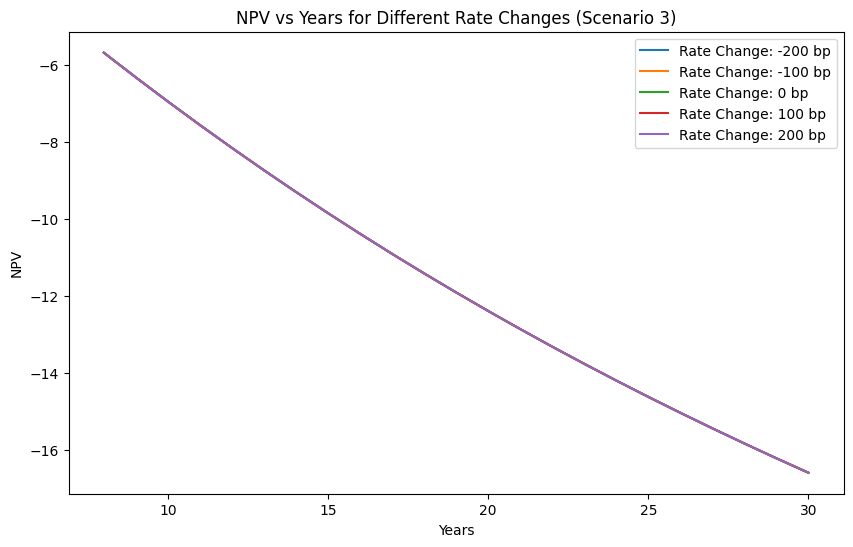

In [196]:
import matplotlib.pyplot as plt

# Prepare data for plotting
years = range(8, 31)  # Years from 8 to 30
rate_changes = [-200, -100, 0, 100, 200]  # Rate changes

# Initialize a plot
plt.figure(figsize=(10, 6))

# Loop over each rate change and plot the corresponding NPVs
for change in rate_changes:
    npvs = [Scenarios['scenario_3'][f"{year}yr"][f"{change/10:+.0f}%"] for year in years]
    plt.plot(years, npvs, label=f"Rate Change: {change} bp")

# Adding labels and title
plt.xlabel('Years')
plt.ylabel('NPV')
plt.title('NPV vs Years for Different Rate Changes (Scenario 3)')
plt.legend()

# Show the plot
plt.show()


In [40]:
Scenarios

{'scenario_1': 1.5399002750707318,
 'scenario_2': {'5yr': {'0%': {'No': 1.539909837007399,
    'Yes': 1.539909837007399},
   '25%': {'No': 1.5388906625839152, 'Yes': 1.5388906625839152},
   '50%': {'No': 1.5378986245875788, 'Yes': 1.5378986245875788},
   '100%': {'No': 1.5359928566916392, 'Yes': 1.5359928566916392},
   '150%': {'No': 1.5341865823704228, 'Yes': 1.5341865823704228}},
  '7yr': {'0%': {'No': 1.5399098370151478, 'Yes': 1.5399098370151478},
   '25%': {'No': 1.5388906625899372, 'Yes': 1.5388906625899372},
   '50%': {'No': 1.537898624592259, 'Yes': 1.537898624592259},
   '100%': {'No': 1.5359928566944663, 'Yes': 1.5359928566944663},
   '150%': {'No': 1.5341865823721312, 'Yes': 1.5341865823721312}}},
 'scenario_3': {'8yr': 1.539909837015148,
  '9yr': 1.539909837015148,
  '10yr': 1.539909837015148,
  '11yr': 1.539909837015148,
  '12yr': 1.539909837015148,
  '13yr': 1.539909837015148,
  '14yr': 1.539909837015148,
  '15yr': 1.539909837015148,
  '16yr': 1.539909837015148,
  '17yr':

## Bootstrap method: 
- Currently not sure which bonds to use to find zero rates

In [14]:
def bootstrap_yield_curve(df, payments_per_year):
    """
    Bootstrap method to determine the zero curve based on bond data.

    Parameters:
        df (pd.DataFrame): DataFrame containing bond data with columns 'Time to Maturity', 'Bond price',
            'Bond Principal', 'Coupon per year'.
        payments_per_year (int): Number of coupon payments per year.

    Returns:
        dict: A dictionary containing zero rates for various maturities.

    This function uses the bootstrap method to determine the zero curve based on bond data provided in a DataFrame.
    It calculates zero rates for different maturities by iterating through the bonds and considering their cash flows.
    """
    zero_rates = {}

    for index, bond in df.iterrows():
        TTM = bond['Time to Maturity']
        price = bond['Bond price']
        principle = bond['Bond Principal']
        coupon_rate = bond['Coupon per year'] * payments_per_year

        if coupon_rate == 0:
            # Zero-coupon bond
            zero_rate = -np.log(price / principle) * 1 / TTM
        else:
            # Coupon-bearing bond
            total_discounted_cash_flow = []
            for t in np.arange(0.5, TTM + 0.5, 0.5):
                cash_flow = coupon_rate

                if t in zero_rates:
                    discount_factor = np.exp(-zero_rates[t] * t)
                    total_discounted_cash_flow.append(cash_flow * discount_factor)

            coupon_payment = np.sum(total_discounted_cash_flow)

            zero_rate = -np.log((price - coupon_payment) / (principle + coupon_rate)) * (1 / TTM)

        zero_rates[TTM] = zero_rate
        df.loc[index, 'zero_rate'] = zero_rate

    return zero_rates


bootstrap_yield_curve(bondtest_data, 0.5)

{0.5: 0.10469296074441824,
 1.0: 0.10536051565782628,
 1.5: 0.10680926388170528,
 2.0: 0.10808027549746793}